In [10]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))


print("¿GPU disponible?:", tf.config.list_physical_devices('GPU'))

¿GPU disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lingfeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
train = Loader.load_NLP()[:80000]

/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

In [12]:
def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
def filter_train_data(train):
    descriptions = [col for col in train.columns if "description" in col]
    train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
    filtered_columns = ["price", "km", "fuelType", "full_description"]
    train = train[filtered_columns]
    train.dropna(inplace=True)
    return train

train = filter_train_data(train)

/tmp/ipykernel_4453/3131217506.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


In [13]:
#Parameters
verb_size = 150

In [15]:
# Load data (assuming df is your DataFrame containing the required columns)
texts = train['full_description'].values  # descriptions
# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=verb_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences,  maxlen=verb_size, padding='post')

In [16]:
train_data, test_data, train_prices, test_prices, train_km, test_km = train_test_split(
    data, train['price'], train['km'], test_size=0.2, random_state=42, stratify=train['fuelType'])

In [17]:
print(test_prices.shape)
print(train['km'].shape)
print(train_km.shape)
print(test_km.shape)

(8000,)
(40000,)
(32000,)
(8000,)


In [21]:
train_data = tf.convert_to_tensor(train_data, dtype=tf.int32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.int32)

I0000 00:00:1730730222.114461    4453 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730730222.114935    4453 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730730222.115136    4453 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730730222.200097    4453 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [22]:
train_prices = tf.convert_to_tensor(train_prices, dtype=tf.float32)
test_prices = tf.convert_to_tensor(test_prices, dtype=tf.float32)

In [23]:
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)

In [24]:
train_data.shape

TensorShape([32000, 150])

In [25]:
# Text input branch
text_input = Input(shape=(train_data.shape[1],), dtype='int32')
text_embed_layer = Embedding(input_dim=verb_size, output_dim=verb_size, input_length=train_data.shape[1])
text_embed = text_embed_layer(text_input)
lstm_out = LSTM(128)(text_embed)

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
# Embedding input branch

# KM branch
input_km = Input(shape=(1,), name='km_input')
km_processed = Dense(32, activation='linear')(input_km)

# Concatenate both branches
concat = Concatenate()([lstm_out, km_processed])
hidden = Dense(256, activation='relu')(concat)
output = Dense(1, activation='linear')(hidden)  # Output layer for price prediction

model = Model(inputs=[text_input, input_km], outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 150, 150)  │     22,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    142,848 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     41,216 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 206,885 (808.14 KB)

 Trainable params: 206,885 (808.14 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
print(train_data.shape)      # Should be (number of samples, sequence length)
#print(train_embeddings.shape)
print(train_km.shape)

(32000, 150)
(32000,)


In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error', "mean_absolute_percentage_error"])

In [29]:
# Train the model
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit([train_data, train_km], train_prices,
          validation_data=([test_data, test_km], test_prices),
          epochs=128, batch_size=32)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/128


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-11-04 15:23:45.001009: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18468.7168 - mean_absolute_error: 18468.7168 - mean_absolute_percentage_error: 97.5901

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 18468.0156 - mean_absolute_error: 18468.0156 - mean_absolute_percentage_error: 97.5801 - val_loss: 17108.0137 - val_mean_absolute_error: 17108.0137 - val_mean_absolute_percentage_error: 73.2092
Epoch 2/128
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 16321.1182 - mean_absolute_error: 16321.1182 - mean_absolute_percentage_error: 80.1866 - val_loss: 11807.1816 - val_mean_absolute_error: 11807.1816 - val_mean_absolute_percentage_error: 53.1655
Epoch 3/128
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 11172.6758 - mean_absolute_error: 11172.6758 - mean_absolute_percentage_error: 50.7582 - val_loss: 7383.0620 - val_mean_absolute_error: 7383.0620 - val_mean_absolute_percentage_error: 25.4873
Epoch 4/128
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7825.0796 - mean_absolute_error: 7825.0796 - mean_absolute_percentage_error: 34.5802 - val_loss: 6532.1992 - val_mean_absolute_error: 6532.1992 - val_mean_absolute_percentage_error

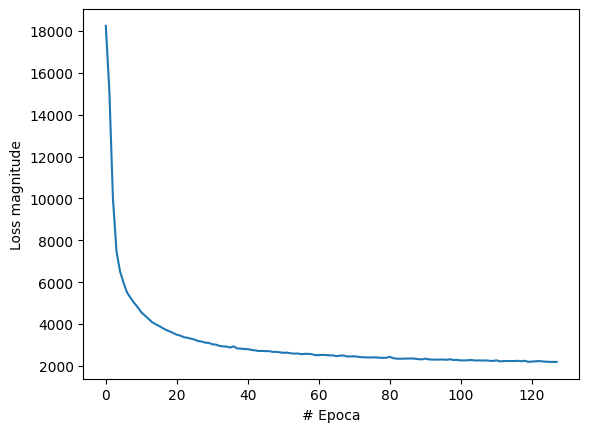

In [30]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

In [32]:
predicted_prices = model.predict([test_data, test_km])

# Assuming test_prices is a 1D array, we can convert it to a DataFrame
results_df = pd.DataFrame({
    'Actual Price': test_prices,
    'Predicted Price': predicted_prices.flatten(),  # Flatten in case it's a 2D array
    'km' : test_km
})

# Display the first few rows of the DataFrame
print(results_df.head())

 34/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
        Actual Price  Predicted Price        km
idx                                            
63552        16200.0     18615.005859   99999.0
123771       65900.0     50581.660156   63800.0
128011       21500.0     22131.556641       0.0
119993       12600.0     13932.817383   50191.0
65724        10999.0     11200.119141  122279.0
